# Generating Pokemon Using GANs

This notebook generating pokemon using a WGAN with gradient penalties. The notebook has 7 sections:

1. Saying hello to our Pokemon
2. Cleaning the images
3. Building the generator network and discriminator network
4. Defining the loss and optimizer
5. Building the model
6. Training
7. Results

In [52]:
import os
import tensorflow as tf
from helper_functions import *
from scipy.io import loadmat
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy
import random
import imageio
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

In [53]:
#Defining the hyperparameters according to the default in the Improving WGANs paper
REAL_SIZE = (128,128,3)
FAKE_SIZE = 100
G_LEARNING_RATE = 0.0001
D_LEARNING_RATE = 0.0001
BATCH_SIZE = 32
STEPS = 900000
BETA1 = 0.0
BETA2 = 0.9

## 1: Hello Pokemon

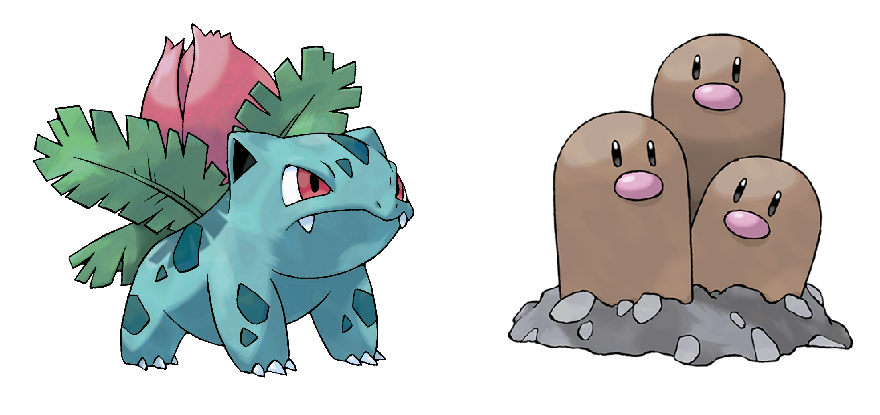

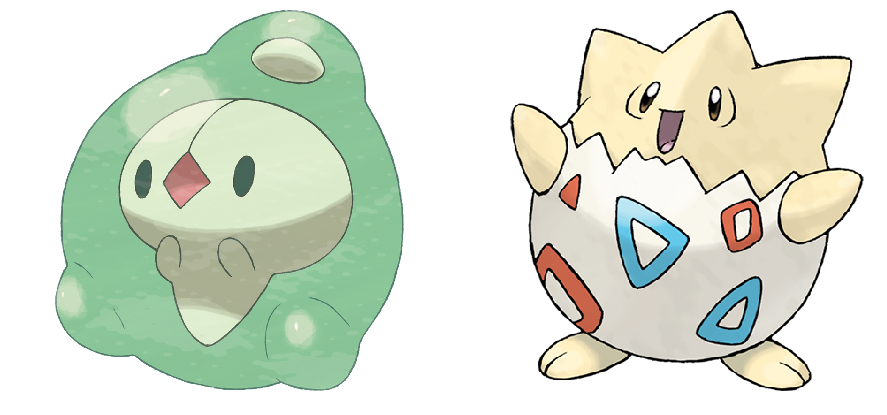

In [110]:
#Fetch the image paths
cwd = os.getcwd()
pokemon_directory = os.path.join(cwd, 'real_pokemon_images')
pokemon_images = []
for pokemon_image in os.listdir(pokemon_directory):
    pokemon_images.append(os.path.join(pokemon_directory, pokemon_image))

#Display some nice pokemon!
first_row_images = [pokemon_images[15], pokemon_images[61]]
second_row_images = [pokemon_images[38], pokemon_images[56]]

showImagesHorizontally(first_row_images)
showImagesHorizontally(second_row_images)
plt.show()

# 2: Cleaning the Images

In [63]:
#Clean the pokemon images so they are ready to go into a model
all_img = []

for image in pokemon_images:
    try:
        img_data = Image.open(image)
        img_data = img_data.convert('RGBA')
        img_data = img_data.resize((REAL_SIZE[0], REAL_SIZE[1]), Image.BILINEAR)
        img_data = np.array(img_data)
        
        #This deals with the transparency values
        for x in range(REAL_SIZE[0]):
            for y in range(REAL_SIZE[1]):
                if img_data[x, y, 3] < 0.01:
                    img_data[x, y, ] = [255., 255., 255., 255.]
        
        img_data = np.delete(img_data, 3, 2)
        all_img.append(img_data)

    except IndexError:
        print("Didn't work for {}".format(image))
               
pokemon_images = all_img  

Now we also fetch some cat images and clean them too. We use other images because it is good to feed the discriminator non-pokemon but real images to help it with its training.

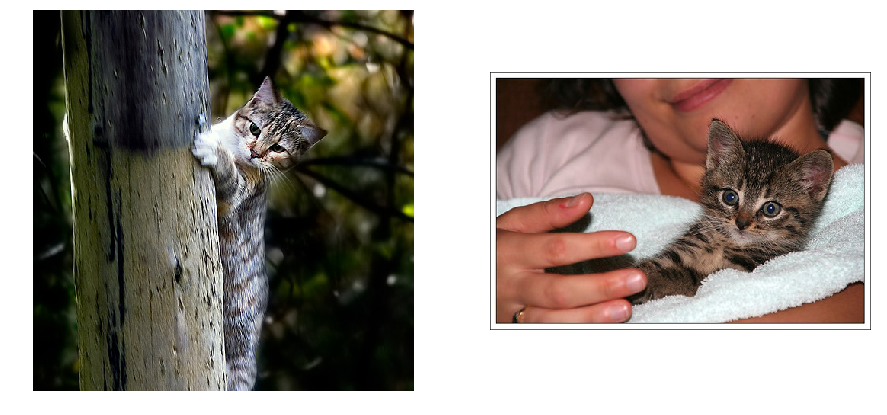

In [9]:
#Fetch cat images
cwd = os.getcwd()
cat_directory = os.path.join(cwd, 'cat_images')
cat_images = []
for cat_image in os.listdir(cat_directory):
    cat_images.append(os.path.join(cat_directory, cat_image))

#Display some cats
first_row_images = [cat_images[40], cat_images[45]]

showImagesHorizontally(first_row_images)
plt.show()


In [10]:
#Clean the cat images
all_img = []
for image in cat_images:
    try:
        img_data = Image.open(image)
        img_data = img_data.convert('RGBA')
        img_data = img_data.resize((REAL_SIZE[0], REAL_SIZE[1]), Image.BILINEAR)
        img_data = np.array(img_data)
        
        #This deals with the transparency values
        for x in range(REAL_SIZE[0]):
            for y in range(REAL_SIZE[1]):
                if img_data[x, y, 3] < 0.01:
                    img_data[x, y, ] = [255., 255., 255., 255.]
        
        img_data = np.delete(img_data, 3, 2)
        all_img.append(img_data)

    except IndexError:
        print("Didn't work for {}".format(image))
               
    
cat_images = all_img  

## 3: Building the Generator & Discriminator Networks

We built two separate networks: the **generator network** and the **discriminator network**.


Some things to note when building a **generator network**:

- Unlike in a normal CNN, we want to use de-convolutions rather than convolutions
- We need to use batch normalisation
- Leaky Relu has been found to be one of the best activation functions for GANs in the discriminator but a normal Relu is better in the generator

In [13]:
def generator_network(input_noise, reuse=False, training=True):
    
    generator_config = {'kernel_size': 5,
                        'strides': 2,
                        'padding': 'same',
                        'kernel_initializer': tf.truncated_normal_initializer(stddev=0.02)}
    
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(input_noise, 4*4*512, \
                             kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))

        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.nn.relu(x1)
        #4x4x512

        x2 = tf.layers.conv2d_transpose(x1, 256, **generator_config)
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.nn.relu(x2)
        #8x8x256

        x3 = tf.layers.conv2d_transpose(x2, 128, **generator_config)
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.nn.relu(x3)
        #16x16x128

        x4 = tf.layers.conv2d_transpose(x3, 64, **generator_config)
        x4 = tf.layers.batch_normalization(x4, training=training)
        x4 = tf.nn.relu(x4)
        #32x32x64

        x5 = tf.layers.conv2d_transpose(x4, 32, **generator_config)
        x5 = tf.layers.batch_normalization(x5, training=training)
        x5 = tf.nn.relu(x5)
        #64x64x32

        #Output layer
        logits = tf.layers.conv2d_transpose(x5, 3, **generator_config)
        #128x128x3

        generator_output = tf.tanh(logits)

        return generator_output

Some things to note when building a **discriminator network**:

- Unlike with the generator, we want to use normal convolutions
- We don't want to use batch normalisation for the discriminator network because WGANs with gradient penalties work better without it
- Again we want to use Leaky Relu

In [37]:
def discriminator_network(generator_output, reuse=False):
    
    discriminator_config = {'kernel_size': 5,
                            'strides': 2,
                            'padding': 'same',
                            'kernel_initializer': tf.truncated_normal_initializer(stddev=0.02)}                                                                            
    
    with tf.variable_scope('discriminator', reuse=reuse):
        #Input is 128x128x3
        
        x1 = tf.layers.conv2d(generator_output, 32, **discriminator_config)
        x1 = lrelu(x1)
        #64x64x32

        x2 = tf.layers.conv2d(x1, 64, **discriminator_config)
        x2 = lrelu(x2)
        #32x32x64

        x3 = tf.layers.conv2d(x2, 128, **discriminator_config)
        x3 = lrelu(x3)
        #16x16x128

        x4 = tf.layers.conv2d(x3, 256, **discriminator_config)
        x4 = lrelu(x4)
        #8x8x256

        #Flatten it
        flattened = tf.reshape(x4, (-1, 8*8*256))
        logits = tf.layers.dense(flattened, 1, \
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        out = tf.sigmoid(logits)

        return out, logits

## 4: Defining the Loss and Optimizer

We will use the WGAN loss with gradient penalty as it was recently shown to work best in many circumstances by the "Improving training of Wasserstein GANs" Dec 2017 paper.

In [38]:
def model_loss_and_accuracy(input_fake, input_real, cat_image, cat_images, LAMBDA=15.0):

    real_prob_real, d_model_real_logits = discriminator_network(input_real)
    
    #If cat_image is yes then we show the discriminator an image of a cat instead of an image from the generator
    if cat_image == "YES":
        fake_prob_real, d_model_fake_logits = discriminator_network(cat_images, reuse=True)
    
    else:
        g_model = generator_network(input_fake, training=True)
        fake_prob_real, d_model_fake_logits = discriminator_network(g_model, reuse=True)
    
    #Calculate the WGAN generator loss
    g_loss = -tf.reduce_mean(d_model_fake_logits)
          
    #Calculate the WGAN discrinator loss with a gradient penalty
    d_loss = tf.reduce_mean(d_model_fake_logits) - tf.reduce_mean(d_model_real_logits)
    
    #This part add a gradient penalty which is an alternative to gradient 
    #clipping that works better
    alpha = tf.random_uniform(shape=[BATCH_SIZE, 1, 1, 1],
                              minval=0.,
                              maxval=1.)
    differences = g_model - input_real
    
    interpolates = input_real + (alpha*differences)
    gradients = tf.gradients( ys = discriminator_network(interpolates, reuse=True)\
                             , xs=[interpolates])[0]
    
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
    gradient_penalty  = tf.reduce_mean((slopes-1.)**2)
    d_loss += LAMBDA*gradient_penalty
    
    real_prob_real = tf.reduce_mean(real_prob_real)
    fake_prob_real = tf.reduce_mean(fake_prob_real)    
    

    return d_loss, g_loss, real_prob_real, fake_prob_real  

Note for the optimizer we wrap the train operations with tf.control_dependencies so that the batch normalization layer can update their population statistics.

In [39]:
def model_optimizer(d_loss, g_loss, d_learning_rate, g_learning_rate, beta1, beta2):
    
    #collect the different variables
    all_variables = tf.trainable_variables()
    d_vars = [var for var in all_variables if var.name.startswith('discriminator')]
    g_vars = [var for var in all_variables if var.name.startswith('generator')]            

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(d_learning_rate, beta1=beta1, \
                                             beta2=beta2).minimize(d_loss, var_list=d_vars,\
                                                                   colocate_gradients_with_ops=True)
        g_train_opt = tf.train.AdamOptimizer(g_learning_rate, beta1=beta1, \
                                             beta2=beta2).minimize(g_loss, var_list=g_vars,\
                                                                   colocate_gradients_with_ops=True)  #TOOK OUT BETA2
                
    return d_train_opt, g_train_opt

## 5: Building the Model

In [40]:
class WGAN:
    def __init__(self, real_size, fake_size, d_learning_rate, g_learning_rate, beta1, beta2):
        tf.reset_default_graph()

      #Create the input placeholders
        self.input_real = tf.placeholder(tf.float32, \
                                         (BATCH_SIZE, real_size[0], \
                                          real_size[1], real_size[2]), name='input_real')
        self.input_fake = tf.placeholder(tf.float32, \
                                         (BATCH_SIZE, fake_size), name='input_fake')
        self.cat_image = tf.placeholder(tf.string, name="cat_image")
        self.cat_images = tf.placeholder(tf.float32, (BATCH_SIZE, real_size[0], \
                                                      real_size[1], real_size[2]),\
                                         name='cat_images')
      

      #Create the losses
        self.d_loss, self.g_loss, self.real_prob_real, \
        self.fake_prob_real = model_loss_and_accuracy(self.input_fake,
                                                      self.input_real, 
                                                      self.cat_image, 
                                                      self.cat_images)

      #Create the optimizers
        self.d_optimizer, self.g_optimizer = model_optimizer(self.d_loss,
                                                             self.g_loss, 
                                                             d_learning_rate=d_learning_rate, 
                                                             g_learning_rate=g_learning_rate, 
                                                             beta1=beta1, 
                                                             beta2=beta2)  

## 6: Train the Model

In [41]:
#Creating the data generator

img_gen = ImageDataGenerator(
    #Normalise the values between -1 and +1
    preprocessing_function = lambda x: 2.0*(x/255.0) - 1.0, 
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode='nearest',
)

In [71]:
def train(network, STEPS):

    saver = tf.train.Saver(max_to_keep=None)
    samples, losses = [], []

    with tf.Session() as sess:  
        
        sess.run(tf.global_variables_initializer())        
        sess.run(tf.local_variables_initializer()) 
        
        img_iter = img_gen.flow(np.stack(pokemon_images), batch_size=BATCH_SIZE)
        cat_img_iter = img_gen.flow(np.stack(cat_images), batch_size=BATCH_SIZE)
        generator_chance = 0.16
        
        #Initialise the probabilities
        real_prob_real = 1.0
        fake_prob_real = 0.5
        
        steps = -1        
        for real_image in img_iter:
            if steps == STEPS: #training is over when this happens
                break
            if real_image.shape[0] == BATCH_SIZE:
                steps += 1            
                fake_batch = np.random.uniform(-1, 1, size=(BATCH_SIZE, FAKE_SIZE))
                
                
                #Sometimes we let the discriminator or generator train for 100 iterations in a row                
                if random.random() < 0.001:
                    print("boosting the discriminator")
                    for iteration in range(100):
                        real_image = img_iter.next()
                        if real_image.shape[0] != BATCH_SIZE:
                            real_image = img_iter.next()
                        fake_batch = np.random.uniform(-1, 1, size=(BATCH_SIZE, FAKE_SIZE))
                        _ = sess.run(network.d_optimizer, feed_dict={network.input_real: real_image,\
                                                                     network.input_fake: fake_batch,
                                                                     network.cat_image: "NO"})
                        
                if random.random() < 0.0001:
                    print("boosting the generator")
                    for iteration in range(100):
                        real_image = img_iter.next()
                        if real_image.shape[0] != BATCH_SIZE:
                            real_image = img_iter.next()
                        fake_batch = np.random.uniform(-1, 1, size=(BATCH_SIZE, FAKE_SIZE))
                        _ = sess.run(network.g_optimizer, 
                                     feed_dict={network.input_real: real_image,
                                                 network.input_fake: fake_batch,
                                                 network.cat_image: "NO" })

                #Otherwise the probability of one or the other training is determined by how well they are performing relative to each other                                
                if random.random() < generator_chance:
                    _ = sess.run(network.g_optimizer, feed_dict={network.input_real: real_image,
                                                                 network.input_fake: fake_batch,
                                                                 network.cat_image: "NO" })
                
                else:
                    #5% of the time we show the discriminator a cat picture
                    if random.random() < 0.95:
                        _ = sess.run(network.d_optimizer,
                                     feed_dict={network.input_real: real_image,
                                                network.input_fake: fake_batch,
                                                network.cat_image: "NO"})

                                                                     
                    
                    else:
                        cat_batch = cat_img_iter.next()
                        if cat_batch.shape[0] != BATCH_SIZE:
                            cat_batch = cat_img_iter.next()
                        _ = sess.run(network.d_optimizer,
                                     feed_dict={network.input_real: real_image,
                                                network.input_fake: fake_batch,
                                                network.cat_image: "YES",
                                                network.cat_images: cat_batch})                                                                                                                                                                                                               
                        
                        
                if steps % 500 == 0:
                    train_loss_d, train_loss_g, real_prob_real, fake_prob_real = \
                    sess.run([network.d_loss, network.g_loss, \
                              network.real_prob_real, network.fake_prob_real],
                             feed_dict={network.input_real: real_image,
                                        network.input_fake: fake_batch,
                                        network.cat_image: "NO"})     
                    
                    #Update the probability of a generator iteration depending on how well it is doing
                    if real_prob_real < 0.8 or fake_prob_real > 0.7:
                        generator_chance = max(0.01, generator_chance - min(0.1*generator_chance, 0.1))
                    
                    elif fake_prob_real < 0.35:
                        generator_chance = min(99.0, generator_chance + max(generator_chance*0.1, 0.1))
                    
                    print("Step {}".format(steps))
                    print("Discriminator loss: {}".format(train_loss_d))
                    print("Generator loss: {}".format(train_loss_g))
                    print("Real_prob_real: {}".format(real_prob_real))
                    print("Fake_prob_real: {}".format(fake_prob_real))
                    print("Generator chance: {}".format(generator_chance))                        
                    
                    saver.save(sess, os.getcwd(), global_step=steps)
                    
                if steps % 10000 == 0:
                    gen_samples = sess.run(generator_network(network.input_fake, reuse=True, training=False),
                                           feed_dict={network.input_fake: fake_batch})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 4, 4, figsize=(10, 10))
                    plt.show()  

    return losses, samples                    

In [72]:
#Creating the network
network = WGAN(REAL_SIZE, FAKE_SIZE, D_LEARNING_RATE, G_LEARNING_RATE, beta1=BETA1, beta2=BETA2)

In [ ]:
losses, samples = train(network, STEPS)

## 7: The Results

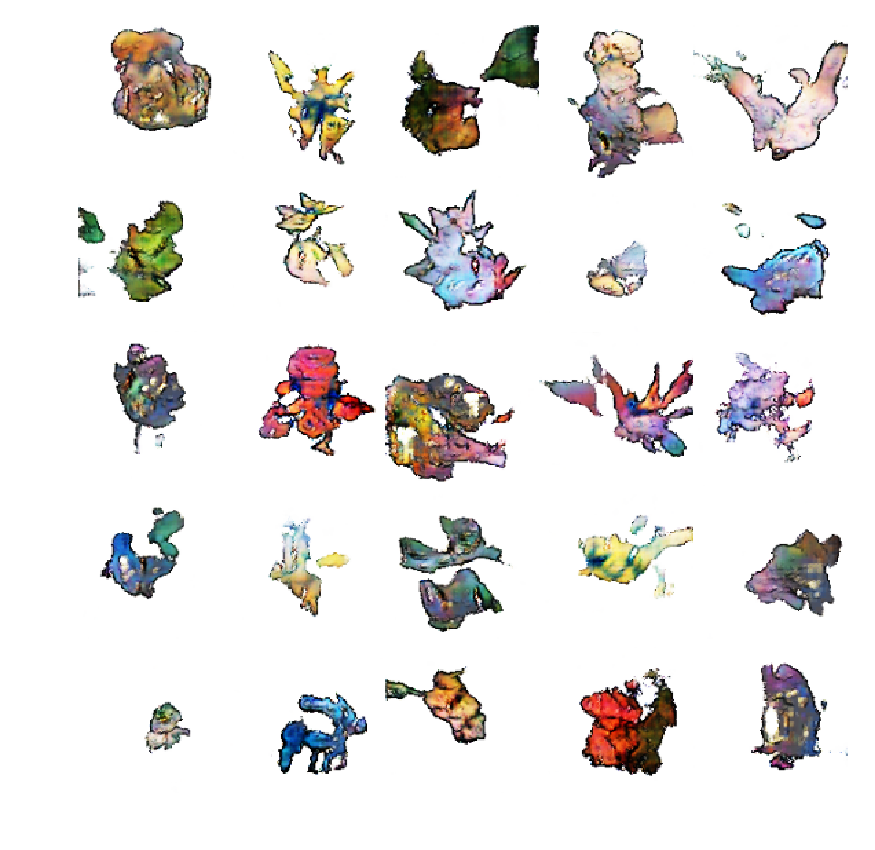

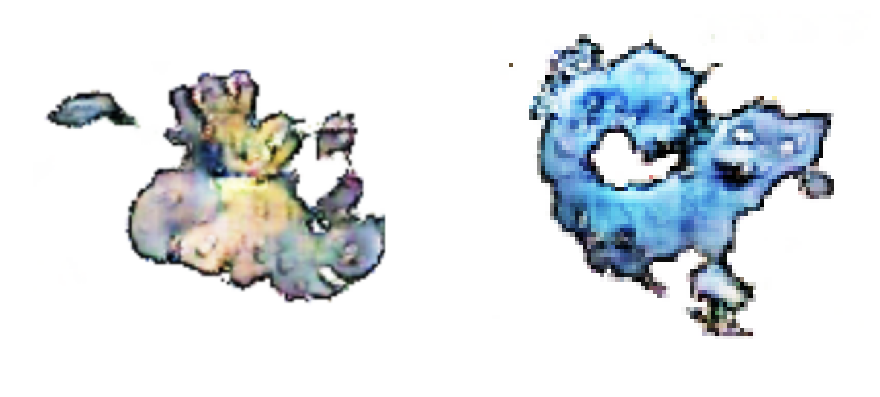

In [79]:
#Fetch the image paths
cwd = os.getcwd()
generated_pokemon_directory = os.path.join(cwd, 'generated_pokemon')
generated_pokemon_images = []
for pokemon_image in os.listdir(generated_pokemon_directory):
    generated_pokemon_images.append(os.path.join(generated_pokemon_directory, pokemon_image))

#Display some nice pokemon!
first_row_images = [generated_pokemon_images[5]]
second_row_images = [generated_pokemon_images[0], generated_pokemon_images[1]]

showImagesHorizontally(first_row_images)
showImagesHorizontally(second_row_images)
plt.show()